In [1]:
import os
import io
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.environ["ALPHA_VANTAGE_KEY"]='60MP74RUOD4MUHKI'
avkey=os.environ["ALPHA_VANTAGE_KEY"]='60MP74RUOD4MUHKI'
from alpha_vantage.foreignexchange import ForeignExchange
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies

fx = ForeignExchange(key = avkey,output_format = "pandas")
df1, metadata = fx.get_currency_exchange_daily("USD","MXN")
ts = TimeSeries(key=avkey, output_format='pandas')
df, meta_df_AAPL = ts.get_daily(symbol='AAPL', outputsize='full')
df

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2024-04-18,168.03,168.64,166.55,167.04,43122903.0
2024-04-17,169.61,170.65,168.00,168.00,50901210.0
2024-04-16,171.75,173.76,168.27,169.38,73711235.0
2024-04-15,175.36,176.63,172.50,172.69,73531773.0
2024-04-12,174.26,178.36,174.21,176.55,101670886.0
...,...,...,...,...,...
1999-11-05,84.62,88.37,84.00,88.31,3721500.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0


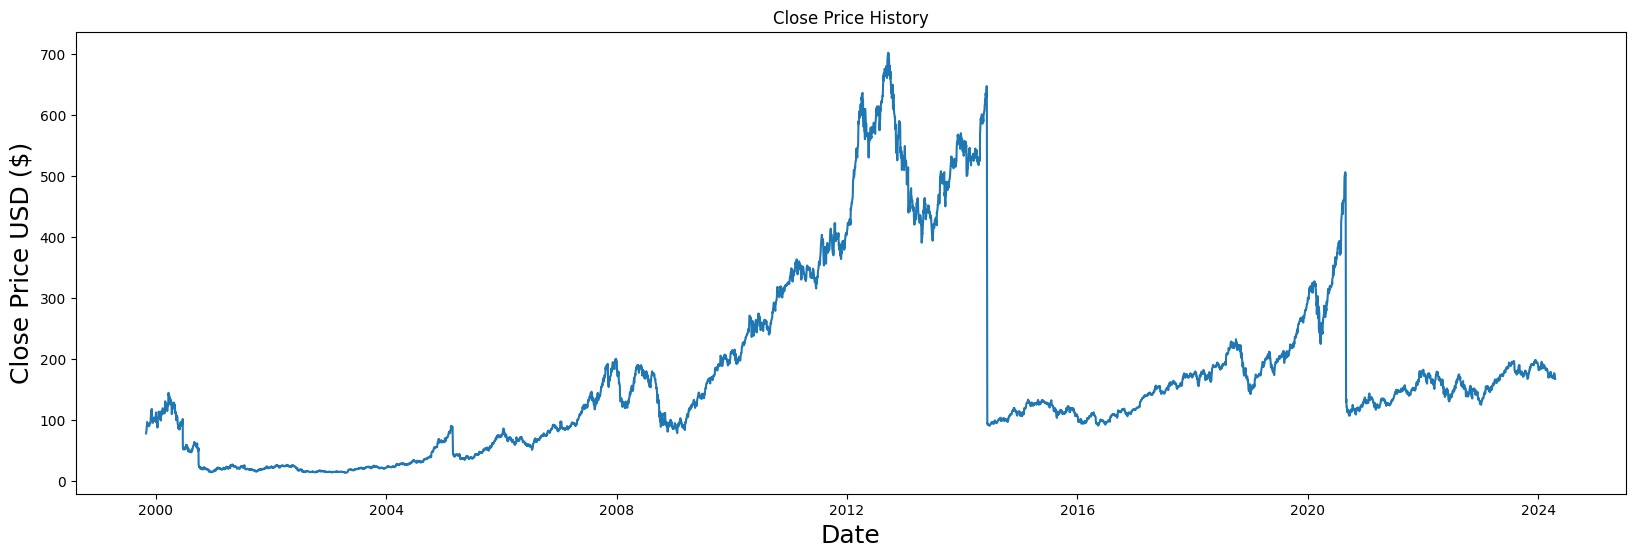

In [2]:
plt.figure(figsize=(20,6))
plt.title('Close Price History')
plt.plot(df['4. close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [3]:
#Create a new dataframe with only the 'Close column
data = df.filter(['4. close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

4924

In [4]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.22340271],
       [0.22479608],
       [0.22679904],
       ...,
       [0.09924816],
       [0.09743389],
       [0.09361665]])

In [5]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.22340271, 0.22479608, 0.22679904, 0.23160324, 0.23720572,
       0.23501408, 0.22447676, 0.22721995, 0.22544921, 0.22708932,
       0.22598624, 0.22719092, 0.22601527, 0.22774246, 0.22984702,
       0.23250312, 0.22727801, 0.22893263, 0.23100816, 0.22968736,
       0.24028274, 0.23652356, 0.2330982 , 0.23150164, 0.23205318,
       0.22933902, 0.23238701, 0.23169032, 0.22875845, 0.2262475 ,
       0.22642167, 0.22787309, 0.23510116, 0.24171964, 0.24330169,
       0.24427414, 0.24603036, 0.24389677, 0.24587071, 0.24855584,
       0.24558042, 0.24447734, 0.24556591, 0.24781561, 0.24823652,
       0.24952829, 0.25259079, 0.2550582 , 0.25428895, 0.255871  ,
       0.25571134, 0.25336004, 0.25070394, 0.25216987, 0.24859938,
       0.25388255, 0.25923829, 0.26023977, 0.26277976, 0.26325873])]
[0.26424569653690966]

[array([0.22340271, 0.22479608, 0.22679904, 0.23160324, 0.23720572,
       0.23501408, 0.22447676, 0.22721995, 0.22544921, 0.22708932,
       0.22598624, 0.22719092, 0.22

In [6]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(4864, 60, 1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

4864/4864 [==============================] - 34s 7ms/step - loss: 0.0011


In [11]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [12]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [13]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [14]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

39/39 [==============================] - 0s 4ms/step


In [15]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3.613512447001785

/var/folders/lt/dm_mvbqj657_k4r2hn7s_2f40000gn/T/ipykernel_9390/1269423473.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


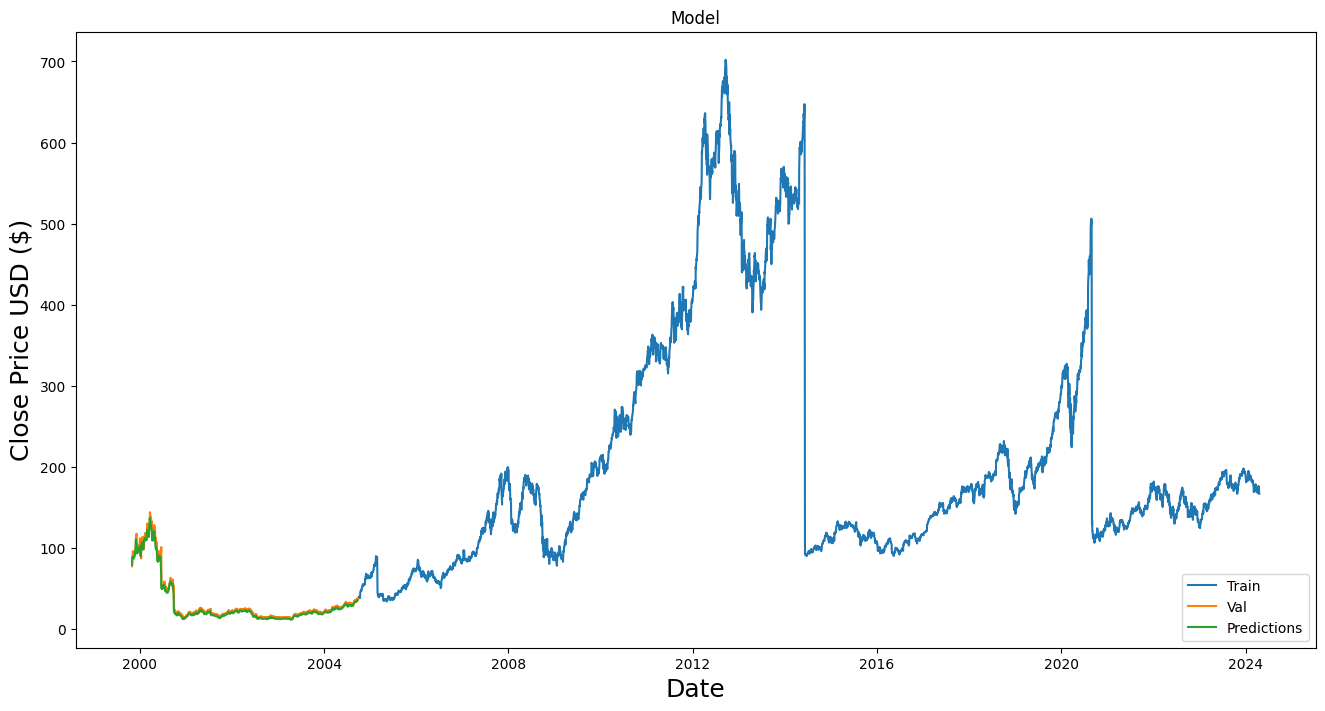

In [17]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['4. close'])
plt.plot(valid[['4. close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
#Show the valid and predicted prices
valid

,4. close,Predictions
date,,
2004-09-24,37.29,35.920555
2004-09-23,37.27,35.543781
2004-09-22,36.92,35.301907
2004-09-21,38.01,35.059193
2004-09-20,37.71,35.278740
...,...,...
1999-11-05,88.31,89.358398
1999-11-04,83.62,88.222176
1999-11-03,81.50,85.122093
